In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [19]:
# Define the start and end dates
start = datetime(2010, 1, 1)
end = datetime(2019, 12, 31)

# Define the location as a Point object (latitude, longitude) for London
loc = Point(51.509858535472475, -0.10653306390618766)

# Initialize a Daily object with the location and the specified time range
data = Daily(loc, pd.to_datetime(start), pd.to_datetime(end))

# Fetch the daily data for the specified location and time range
data = data.fetch()

# Print information about the fetched data
# data.info()


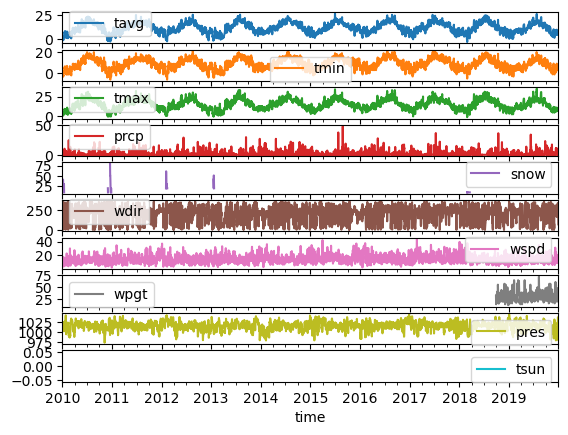

In [20]:
#Plot data
data.plot(subplots=True)
plt.show()

In [21]:
try:
    # Attempt to drop the specified columns if they exist
    data.drop(columns=['snow', 'tsun', 'wpgt'], inplace=True)
except:
    # If the specified columns are not found, print a message
    print("Columns not found")

# Forward-fill missing values along the rows axis
data.ffill(axis='rows', inplace=True)

# Backward-fill missing values along the rows axis
data.bfill(axis='rows', inplace=True)

# Print information about the DataFrame, limiting the number of rows and columns printed to 10
data.info(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2010-01-01 to 2019-12-31
Freq: D
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    3652 non-null   float64
 1   tmin    3652 non-null   float64
 2   tmax    3652 non-null   float64
 3   prcp    3652 non-null   float64
 4   wdir    3652 non-null   float64
 5   wspd    3652 non-null   float64
 6   pres    3652 non-null   float64
dtypes: float64(7)
memory usage: 228.2 KB


In [22]:
# Create a DataFrame 'features' containing selected columns from the original data
features = data[['tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]

# Create a DataFrame 'target' containing the 'tavg' column from the original data
target = data[['tavg']]


In [23]:
def create_dataset(features, target, look_back):
    """
    Create a dataset suitable for sequence prediction tasks using a sliding window approach.

    Parameters:
    features (DataFrame): The predictor variables.
    target (DataFrame): The target variable.
    look_back (int): The number of previous time steps to use as input features.

    Returns:
    tuple: A tuple containing the input features (dataX) and the target variable (dataY).
    """

    dataX, dataY = [], []  # Initialize lists to hold input features and target variable
    
    # Iterate through the features dataframe
    for i in range(len(features) - look_back):
        # Extract a window of look_back time steps as input features
        a = features[i:(i + look_back)]
        # Append the window to dataX
        dataX.append(a)
        # Append the target variable corresponding to the next time step to dataY
        dataY.append(target[i + look_back])
    
    # Convert lists to numpy arrays and return
    return np.array(dataX), np.array(dataY)


In [24]:
# Create a MinMaxScaler object for features, scaling them to the range [0, 1]
scaler_features = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the features and transform them to the scaled version
scaled_features = scaler_features.fit_transform(features)

# Create a MinMaxScaler object for the target variable, scaling it to the range [0, 1]
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the target variable and transform it to the scaled version
scaled_target = scaler_target.fit_transform(target)


In [25]:
# Number of previous time steps to consider
look_back = 21  

# Create input features (X) and target variable (y) using the create_dataset function
X, y = create_dataset(scaled_features, scaled_target, look_back)

# Reshape input features to be in the format [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)  # 80% of the dataset for training
test_size = len(X) - train_size  # Remaining 20% for testing
X_train, X_test = X[:train_size], X[train_size:]  # Split input features
y_train, y_test = y[:train_size], y[train_size:]  # Split target variable


In [26]:
# Initialize a Sequential model
model = Sequential()

# Add a Bidirectional LSTM layer with 50 units and return sequences to maintain the sequence for the next LSTM layer
# Specify the input shape as (look_back, number of features)
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, X.shape[2])))

# Add another Bidirectional LSTM layer with 50 units; it will return the last output in the output sequence
model.add(Bidirectional(LSTM(50)))

# Add a Dense layer with 1 unit to output the prediction
model.add(Dense(1))

# Compile the model using the Adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 21, 100)          22800     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 83,301
Trainable params: 83,301
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Fit the model to the training data
model.fit(X_train, y_train, epochs=25, batch_size=1)

# Make predictions on training and testing datasets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the scaled predictions back to their original scale
train_predict = scaler_target.inverse_transform(train_predict)
y_train = scaler_target.inverse_transform(y_train)
test_predict = scaler_target.inverse_transform(test_predict)
y_test = scaler_target.inverse_transform(y_test)


Epoch 1/25
2904/2904 [==============================] - 19s 6ms/step - loss: 0.0066
Epoch 2/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0042
Epoch 3/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0041
Epoch 4/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0039
Epoch 5/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0038
Epoch 6/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0037
Epoch 7/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0036
Epoch 8/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0036
Epoch 9/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0035
Epoch 10/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0035
Epoch 11/25
2904/2904 [==============================] - 17s 6ms/step - loss: 0.0034
Epoch 12/25
2904/2904 [==============================] - 17s 6ms/step - lo

In [28]:
# Calculate the root mean squared error (RMSE) for the training predictions
train_score = math.sqrt(mean_squared_error(y_train, train_predict))

# Calculate the root mean squared error (RMSE) for the testing predictions
test_score = math.sqrt(mean_squared_error(y_test, test_predict))

# Print the RMSE scores for both training and testing datasets
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')


Train Score: 1.54 RMSE
Test Score: 1.67 RMSE


In [29]:
# Define the start and end dates for fetching new data
start = datetime(2020, 1, 1)
end = datetime(2024, 12, 31)

# Fetch new data from 2020 to 2024
data_new = Daily(loc, pd.to_datetime(start), pd.to_datetime(end))
data_new = data_new.fetch()

try:
    # Drop columns 'snow' and 'tsun' if they exist in the new data
    data_new.drop(columns=['snow', 'tsun'], inplace=True)
except:
    # If the specified columns are not found, print a message
    print("Columns not found")

# Fill missing values using forward-fill and backward-fill
data_new.ffill(axis='rows', inplace=True)
data_new.bfill(axis='rows', inplace=True)

# Extract features and target variable from the new data
features_new = data[['tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']]
target_new = data[['tavg']]

# Normalize the new data
scaler_features_new = MinMaxScaler(feature_range=(0, 1))
scaled_features_new = scaler_features_new.fit_transform(features_new)

scaler_target_new = MinMaxScaler(feature_range=(0, 1))
scaled_target_new = scaler_target_new.fit_transform(target_new)

# Prepare the new dataset using the create_dataset function
look_back = 21  # Number of previous time steps to consider
X_new, y_new = create_dataset(scaled_features_new, scaled_target_new, look_back)

# Reshape input features to be in the format [samples, time steps, features]
X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], X_new.shape[2]))

# Make predictions on the new dataset using the trained model
predictions_new = model.predict(X_new)


114/114 [==============================] - 1s 6ms/step


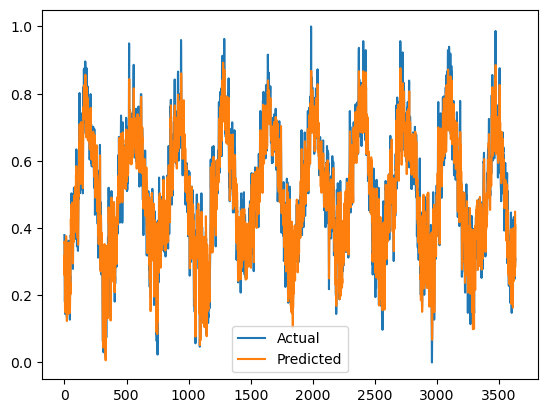

In [30]:
# Create a DataFrame containing actual and predicted values from the new data
data_result = pd.DataFrame({
    'Actual': y_new.flatten(),  # Flatten to convert 2D array to 1D
    'Predicted': predictions_new.flatten()  # Flatten to convert 2D array to 1D
})

# Plot the actual and predicted values
data_result.plot(y=["Actual", "Predicted"])

# Show the plot
plt.show()
